# Análise de dados sobre saúde do sono e estilo de vida

### Insights sobre padrões de sono e hábitos diários

# Visão geral do projeto:
O Sleep Health and Lifestyle Dataset fornece insights detalhados sobre os padrões de sono, hábitos diários e fatores de estilo de vida dos indivíduos. Essa etapa do projeto compreende dados já tratados e organizados para facilitar as análises. 

Essa análise tem como objetivo produzir insights a partir de métricas essenciais como duração do sono, qualidade do sono, níveis de atividade física, estresse, categoria de IMC, saúde cardiovascular e presença de distúrbios do sono.

# Fontes dos dados

Os dados foram obtidos no kaggle através do [link](https://www.kaggle.com/code/winterbearballu/sleep-health-and-lifestyle-eda)

Obs: este conjunto de dados é gerado sinteticamente e se destina exclusivamente a propósitos ilustrativos e educacionais. Ele visa fornecer uma estrutura realista para explorar e analisar correlações entre sono, hábitos de estilo de vida e métricas de saúde.

# Modelagem

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from src.config import DADOS_LIMPOS
from src.models import RANDOM_STATE

sns.set_theme(palette="bright")

In [5]:
df = pd.read_parquet(DADOS_LIMPOS)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Genero                  400 non-null    category
 1   Idade                   400 non-null    int8    
 2   Ocupacao                400 non-null    category
 3   Duracao_sono            400 non-null    float32 
 4   Qualidade_sono          400 non-null    float32 
 5   Nivel_atividade_física  400 non-null    int8    
 6   Nivel_estresse          400 non-null    int8    
 7   IMC                     400 non-null    category
 8   Frequencia_cardiaca     400 non-null    int8    
 9   Passos_diarios          400 non-null    int16   
 10  Disturbio_sono          400 non-null    category
 11  Sistolica               400 non-null    int16   
 12  Diastolica              400 non-null    int8    
dtypes: category(4), float32(2), int16(2), int8(5)
memory usage: 9.0 KB


## Estruturação do modelo

Realizando a análise com regressão logística com o mínimo de tratamento

In [8]:
# Separação do target das demais colunas

X = df.drop(columns="Disturbio_sono")
y = df["Disturbio_sono"]

In [9]:
# Codificando para obter um target numérico

le = LabelEncoder()

y = le.fit_transform(y)

y[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0])

In [10]:
# Realizando treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

Como inicialmente estamos querendo realizar apenas uma análise preliminar do comportamento do modelo, realizaremos o mínimo de tratamento da base.

O objetivo é realizar um pré-processamento inicial pois o modelo linear não reconhece colunas categóricas, sendo necessário a codificação, e para isso utilizaremos as bibliotecas OrdinalEncoder (dados categóricos ordinais) e OneHotEncoder (dados categóricos nominais).

In [12]:
# Selecionar colunas para o pré-processamento

coluna_target = ["Disturbio_sono"]

colunas_ordinal_encoder = ["IMC"]

ordem_imc = [["Underweight", "Normal", "Overweight", "Obese"]]

colunas_one_hot_encoder = df.select_dtypes(include="category").columns.difference(colunas_ordinal_encoder + coluna_target).to_list()

In [13]:
# Construindo pipeline dos dados

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories=ordem_imc), colunas_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(), colunas_one_hot_encoder)
    ],
    remainder="passthrough",
)

In [14]:
pipeline  =Pipeline([
    ("preprocessor", preprocessamento),
    ("clf", LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced"))
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal',
                                                                              'Overweight',
                                                                              'Obese']]),
                                                  ['IMC']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Genero', 'Ocupacao'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    solver='saga'))])

Estrutura da pipeline construída, iniciamos com a regressão logística. Importante destacar o hiperparâmetro "Class_weight" para reduzir a influência do desbalanceamento dos dados.

In [16]:
# Treinando o modelo

pipeline.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\envs\ml_aula\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal',
                                                                              'Overweight',
                                                                              'Obese']]),
                                                  ['IMC']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Genero', 'Ocupacao'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    solver='saga'))])

In [17]:
# Coeficientes gerados a partir do classificador

pipeline["clf"].coef_

array([[-3.63893583e-04, -1.49757876e-04,  1.22291684e-04,
         1.31956618e-04,  7.77545478e-05, -1.00087699e-04,
        -1.37089659e-04,  1.12761610e-03, -3.35635029e-04,
         1.63738160e-05, -2.04737935e-04, -1.58355592e-03,
         2.99747416e-03,  2.05317203e-05, -3.15760052e-03,
        -9.93401406e-04],
       [ 9.40209553e-05,  6.66838381e-05, -6.93321210e-05,
         6.22091550e-05, -1.51671908e-04, -5.30182313e-06,
         9.21162930e-05,  4.15538728e-04, -3.12361340e-04,
        -6.05650896e-05,  7.36849037e-03, -3.03565210e-04,
         1.05425179e-03, -3.44081911e-05, -5.39191283e-04,
        -1.02791325e-03],
       [ 2.69872628e-04,  8.30740375e-05, -5.29595627e-05,
        -1.94165773e-04,  7.39173600e-05,  1.05389522e-04,
         4.49733657e-05, -1.54315482e-03,  6.47996370e-04,
         4.41912736e-05, -7.16375243e-03,  1.88712113e-03,
        -4.05172594e-03,  1.38764708e-05,  3.69679181e-03,
         2.02131465e-03]])

Apenas para fim de entendimento, a regressão logística possui um hiperparâmetro padrão para casos multiclasses denominado "multinomial", em que um único modelo é ajustado para prever todas as classes simultaneamente. Nesse modelo multinomial, são gerados múltiplos conjuntos de coeficientes, um para cada classe, que são usados para calcular as probabilidades relativas entre todas as classes.

Por esse motivo, temos 3 listas que representam as classes e 16 coeficientes que estão relacionados as colunas/features.

In [19]:
# Interceptos gerados para cada classe

pipeline["clf"].intercept_

array([-2.74665926e-05, -2.64823043e-06,  3.01148230e-05])

In [20]:
# Features antes do treinamento

pipeline["preprocessor"].feature_names_in_

array(['Genero', 'Idade', 'Ocupacao', 'Duracao_sono', 'Qualidade_sono',
       'Nivel_atividade_física', 'Nivel_estresse', 'IMC',
       'Frequencia_cardiaca', 'Passos_diarios', 'Sistolica', 'Diastolica'],
      dtype=object)

In [21]:
# Feature após o treinamento (preprocessamento

pipeline["preprocessor"].get_feature_names_out()

array(['ordinal_encoder__IMC', 'one_hot_encoder__Genero_Female',
       'one_hot_encoder__Genero_Male',
       'one_hot_encoder__Ocupacao_Manual Labor',
       'one_hot_encoder__Ocupacao_Office Worker',
       'one_hot_encoder__Ocupacao_Retired',
       'one_hot_encoder__Ocupacao_Student', 'remainder__Idade',
       'remainder__Duracao_sono', 'remainder__Qualidade_sono',
       'remainder__Nivel_atividade_física', 'remainder__Nivel_estresse',
       'remainder__Frequencia_cardiaca', 'remainder__Passos_diarios',
       'remainder__Sistolica', 'remainder__Diastolica'], dtype=object)

In [22]:
# Visualizando os coeficientes para cada classe

coefs = pd.DataFrame(
    data=pipeline["clf"].coef_, 
    index=le.inverse_transform([0, 1, 2]),
    columns=pipeline["preprocessor"].get_feature_names_out()
).T.sort_values(by="No sleep disturbance").round(5)

coefs

,Insomnia,No sleep disturbance,Sleep Apnea
remainder__Diastolica,-0.00099,-0.00103,0.00202
remainder__Sistolica,-0.00316,-0.00054,0.00370
remainder__Duracao_sono,-0.00034,-0.00031,0.00065
remainder__Nivel_estresse,-0.00158,-0.00030,0.00189
one_hot_encoder__Ocupacao_Office Worker,0.00008,-0.00015,0.00007
one_hot_encoder__Genero_Male,0.00012,-0.00007,-0.00005
remainder__Qualidade_sono,0.00002,-0.00006,0.00004
remainder__Passos_diarios,0.00002,-0.00003,0.00001
one_hot_encoder__Ocupacao_Retired,-0.00010,-0.00001,0.00011
one_hot_encoder__Ocupacao_Manual Labor,0.00013,0.00006,-0.00019


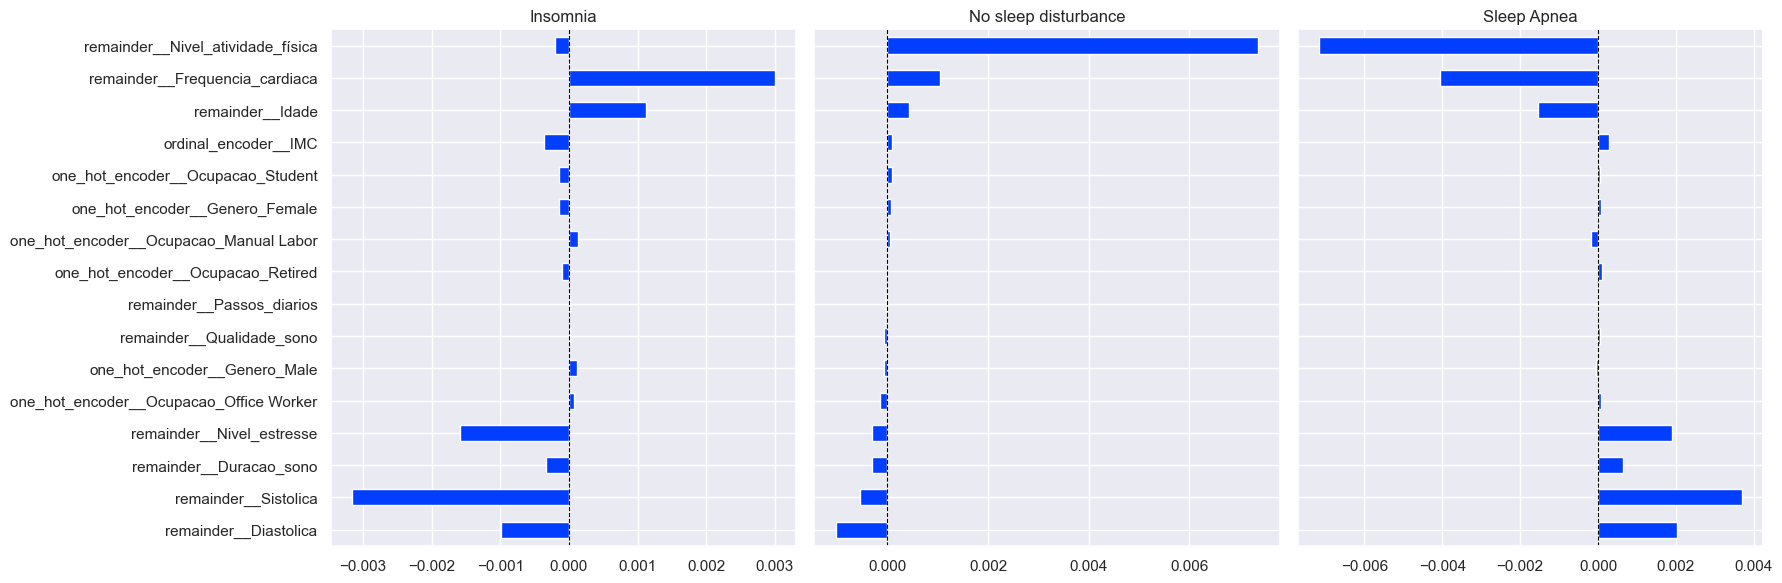

In [23]:
# Criando um gráfico de barras para demonstrar a magnitude dos coeficientes

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, coluna in enumerate(coefs.columns):
    coefs[coluna].plot(
        kind='barh', 
        ax=axs[i], 
        title=coluna
    )
    axs[i].axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

**Importância dos coeficientes**:
   - **Coeficiente positivo**: Um coeficiente positivo significa que, à medida que o valor da feature aumenta, a probabilidade da classe associada a esse conjunto de coeficientes ser prevista também aumenta.
   - **Coeficiente negativo**: Um coeficiente negativo indica que o aumento no valor da feature reduz a probabilidade de a classe associada ser prevista.
   - **Magnitude**: A magnitude dos coeficientes reflete a força da relação entre a feature e a classe correspondente.

Ou seja, podemos observar que algumas features são mais importantes que outras na predição/separação de uma determinada classe:

- Classe "Nenhum distúrbio": Nivel de atividade física, Frequencia cardiaca e Idade.
- Classe "Insonia": Frequencia cardíaca e Idade.
- Classe "Apneia do sono": Nivel de estresse, Pressão Sistolica e Pressão Diastólica.

***Um detalhe que vale a pena notar, o pré-processamento não influenciou na escolha das classes, pois o mesmo serviu apenas para codificar. A partir do momento que começarmos a utilizá-lo para alterar a forma dos dados como, por exemplo, transformação para distribuição normal, pode ser que ocorra maior influência***

In [26]:
# Guardando os valores previstos com base nos dados de testes.

y_pred = pipeline.predict(X_test)

In [27]:
# Primeira métrica obtida para avaliarmos a qualidade do modelo - Score = Acurácia.

pipeline.score(X_test, y_test)

0.525

In [28]:
# Matriz de confusão para verificarmos o quanto o modelo acertou (dados previstos) em relação aos dados reais.

confusion_matrix(y_test, y_pred)

array([[ 4,  6,  6],
       [ 7, 37, 14],
       [ 3,  2,  1]])

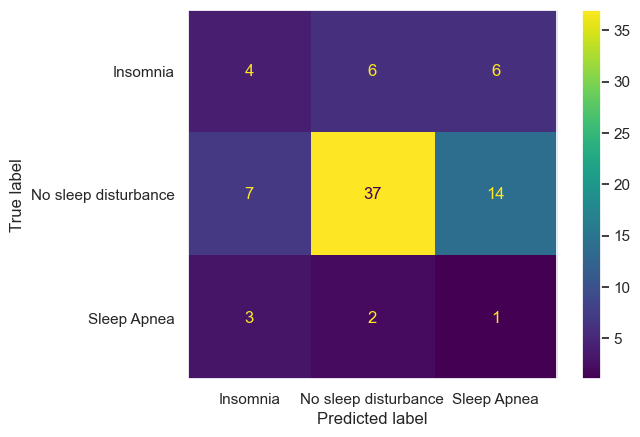

In [29]:
# Visualização gráfica da Matriz de Confusão

fig, ax = plt.subplots()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

ax.grid(False)

disp.plot(ax=ax)

No gráfico acima, podemos ver que o modelo está com poder preditivo significativamente limitado.

In [69]:
np.bincount(y_test)

array([16, 58,  6])

O que mais acertou foi a classe "Nenhum distúrbio" (37 acertos de 58 possíveis - 63%), isso tem a ver com o fato de ser a classe que apresenta maior quantidade de dados. Em seguida, temos "Insônia" (4 de 16 possíveis - 25%) e, por último, "Apneia do Sono" (1 de 6 possíveis - 17%).

**Detalhe Importante**: antes de chegar nesse resultado, realizamos o treinamento do modelo sem o parâmetro "Class Weight" e o resultado obtido foi que o modelo conseguiu predizer apenas a classe "Nenhum distúrbio", demonstrando a influência do desbalanceamento nos resultados.

## Próximas Análises:

Inicialmente, foi realizada uma análise para verificarmos o comportamento dos dados no treianamento do modelo de Regressão Logística com o mínimo de pré-tratamento.

Nas próximas serão incluídos pré-tratamentos visando a correção da distribuição dos dados numéricos que, conforme a análise exploratória, apresentam colunas que não representam uma distribuição normal. Além disso, colunas com escalas de valores diferentes, o que pode prejudicar o desempenho dos modelos.

Além disso, realizaremos tratamentos mais significativos visando conter a influência do desbalanceamento dos dados (preprocessamentos utilizando RandomUnderSampler, RandomOverSampler e SMOTE)

Por último, testar outro tipo de modelo linear (SGDClassifier), além de modelos baseados em árvores (DecisionTreeClassifier e RandomForestClassifier) e modelos baseados em Gradient Boosting (XGboost e LightGBM).